In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from sklearn.metrics import r2_score, accuracy_score
import torch 
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from loguru import logger
import matplotlib.pyplot as plt

from nam.config import defaults
from nam.types import Config
from nam.utils.args import parse_args
from nam.data import NAMDataset
from nam.models import DNN, FeatureNN, NAM, get_num_units
from nam.engine import Engine
from nam.utils import graphing

from main import get_config



In [3]:
X, y = load_boston(return_X_y=True)
X.shape, y.shape

((506, 13), (506,))

In [4]:
batch_size=64

In [5]:
scaler = MinMaxScaler()

X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2137)

X_train = torch.from_numpy(X_train.astype('float32'))
X_test = torch.from_numpy(X_test.astype('float32'))
y_train = torch.from_numpy(y_train.reshape(-1, 1).astype('float32'))
y_test = torch.from_numpy(y_test.reshape(-1, 1).astype('float32'))

dataset_train = torch.utils.data.TensorDataset(X_train, y_train)
dataset_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

In [6]:
inputs, targets = next(iter(dataset_train))

In [7]:
inputs.shape, targets.shape

(torch.Size([64, 13]), torch.Size([64, 1]))

In [8]:
config = get_config()
config.shallow = True
config.dropout = 0.0
config.activation='relu'
config.n_models = 10
print(config)

Config(activation='relu', batch_size=1024, cross_val=False, data_split=1, dataset_name='Teleco', debug=False, decay_rate=0.995, device='cpu', dropout=0.0, early_stopping_epochs=60, feature_dropout=0.0, fold_num=1, hidden_sizes=[64, 32], l2_regularization=0.0, learning_rate=0.01, lr=0.01, max_checkpoints_to_keep=1, n_folds=5, n_models=10, num_basis_functions=1000, num_splits=3, num_units=64, num_workers=16, output_dir='output', output_regularization=0.0, patience=10, regression=False, save_checkpoint_every_n_epochs=10, seed=1, shallow=True, shuffle=True, training_epochs=10, units_multiplier=2, use_dnn=False)


In [9]:
models = []
for n in range(config.n_models):
    models.append(NAM(
        config=config,
        name="NAMModel",
        num_inputs=X.shape[1],
        num_units=get_num_units(config, dataset_train)
    ))

In [10]:
models[3]

NAM(
  (feature_nns): Sequential(
    (FeatureNN_0): FeatureNN(
      (model): Sequential(
        (0): LinReLU(in_features=1, out_features=128, bias=True)
        (1): LinReLU(in_features=128, out_features=64, bias=True)
        (2): LinReLU(in_features=64, out_features=32, bias=True)
        (3): LinReLU(in_features=32, out_features=1, bias=True)
      )
    )
    (FeatureNN_1): FeatureNN(
      (model): Sequential(
        (0): LinReLU(in_features=1, out_features=28, bias=True)
        (1): LinReLU(in_features=28, out_features=64, bias=True)
        (2): LinReLU(in_features=64, out_features=32, bias=True)
        (3): LinReLU(in_features=32, out_features=1, bias=True)
      )
    )
    (FeatureNN_2): FeatureNN(
      (model): Sequential(
        (0): LinReLU(in_features=1, out_features=66, bias=True)
        (1): LinReLU(in_features=66, out_features=64, bias=True)
        (2): LinReLU(in_features=64, out_features=32, bias=True)
        (3): LinReLU(in_features=32, out_features=1, bi

In [16]:

for model in models:
    loss_obj = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())
    for i in range(500):
        optimizer.zero_grad()
        for X, y in dataset_train:
            y_pred = model(X)
            loss = loss_obj(y_pred, y)
            loss.backward()
            optimizer.step()
        print(loss)

kward>)
tensor(13.3689, grad_fn=<MseLossBackward>)
tensor(43.7609, grad_fn=<MseLossBackward>)
tensor(44.6879, grad_fn=<MseLossBackward>)
tensor(29.3891, grad_fn=<MseLossBackward>)
tensor(41.2449, grad_fn=<MseLossBackward>)
tensor(32.4886, grad_fn=<MseLossBackward>)
tensor(23.3364, grad_fn=<MseLossBackward>)
tensor(70.7926, grad_fn=<MseLossBackward>)
tensor(47.8499, grad_fn=<MseLossBackward>)
tensor(56.2757, grad_fn=<MseLossBackward>)
tensor(48.1934, grad_fn=<MseLossBackward>)
tensor(93.2242, grad_fn=<MseLossBackward>)
tensor(39.3561, grad_fn=<MseLossBackward>)
tensor(72.9422, grad_fn=<MseLossBackward>)
tensor(35.1162, grad_fn=<MseLossBackward>)
tensor(58.5751, grad_fn=<MseLossBackward>)
tensor(40.3644, grad_fn=<MseLossBackward>)
tensor(13.8881, grad_fn=<MseLossBackward>)
tensor(71.1395, grad_fn=<MseLossBackward>)
tensor(36.1530, grad_fn=<MseLossBackward>)
tensor(38.1931, grad_fn=<MseLossBackward>)
tensor(38.7254, grad_fn=<MseLossBackward>)
tensor(23.0326, grad_fn=<MseLossBackward>)
ten

In [14]:
for model in models:
    y_pred = model(X_test)
    y_test_numpy = y_test.detach().numpy()
    y_pred_numpy = y_pred.detach().numpy()
    print(r2_score(y_test_numpy, y_pred_numpy))

0.7323890691957777
0.5703155491935181
0.727692125449203
0.5956870451705929
0.7884459466914017
0.5526652199078781
0.720565110178333
0.6078176256536448
0.7554222316152286
0.40450792457008977


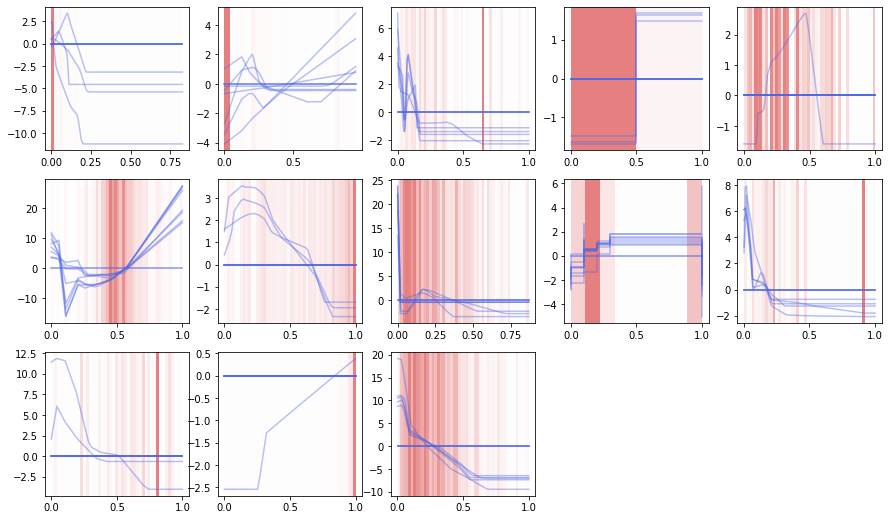

In [17]:
graphing.nam_plot(X_train,models)